# Sentiment Analysis on Movie Reviews

**Objective**: Build a machine learning model to classify movie reviews as positive or negative.

**Dataset**: IMDB Movie Reviews Dataset (50,000 reviews)

**Tools**: Python, scikit-learn, NLTK

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text processing
import nltk
from nltk.corpus import stopwords
import re

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

print("✓ All libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to C:\Users\Ecomp
[nltk_data]     Services\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to C:\Users\Ecomp
[nltk_data]     Services\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


✓ All libraries imported successfully!


In [2]:
# Load the IMDB Dataset
df = pd.read_csv('IMDB Dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\n✓ Dataset loaded successfully!")
print(f"\nFirst few reviews:")
df.head()

Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

✓ Dataset loaded successfully!

First few reviews:


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


Missing Values:
review       0
sentiment    0
dtype: int64


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


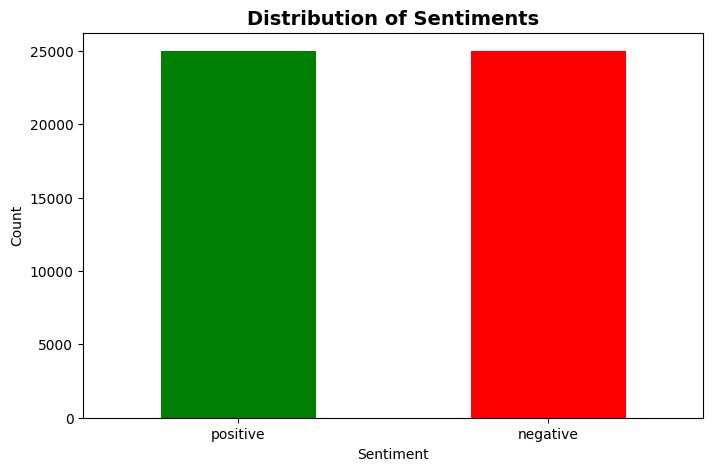

In [3]:
# Check dataset info
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)

# Check sentiment distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

# Visualize sentiment distribution
plt.figure(figsize=(8, 5))
df['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Sentiments', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

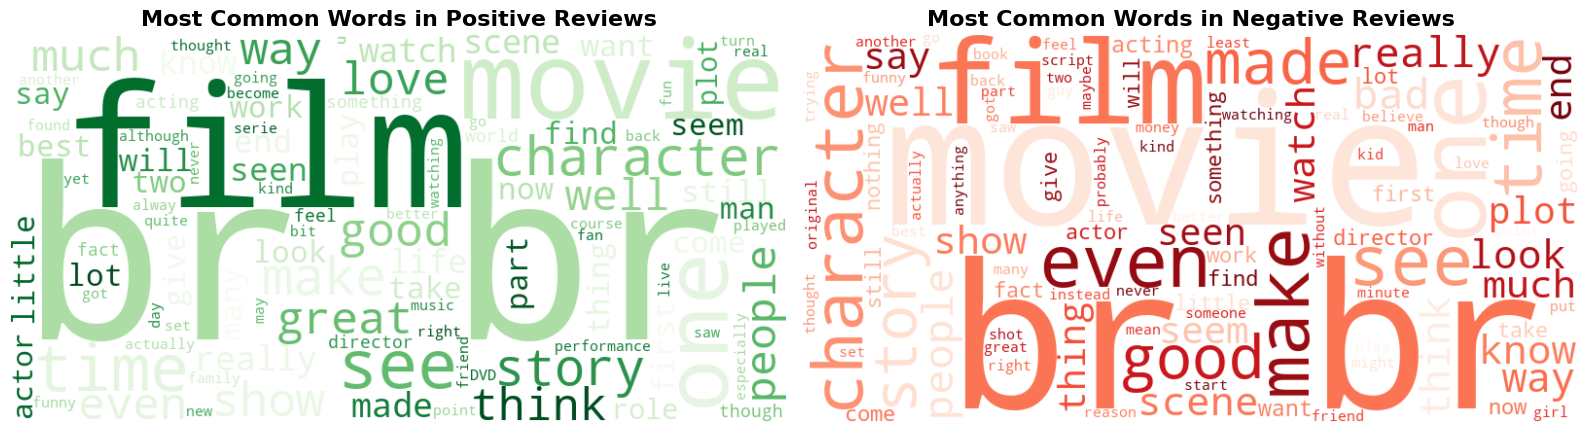

✓ Word clouds generated successfully!


In [4]:
# Separate positive and negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['review']
negative_reviews = df[df['sentiment'] == 'negative']['review']

# Combine all text for each sentiment
positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

# Create word clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive word cloud
wordcloud_pos = WordCloud(width=800, height=400, 
                          background_color='white',
                          colormap='Greens',
                          max_words=100).generate(positive_text)

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Most Common Words in Positive Reviews', fontsize=16, fontweight='bold')
axes[0].axis('off')

# Negative word cloud
wordcloud_neg = WordCloud(width=800, height=400,
                          background_color='white', 
                          colormap='Reds',
                          max_words=100).generate(negative_text)

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Most Common Words in Negative Reviews', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✓ Word clouds generated successfully!")

Review Length Statistics:
             count       mean         std   min    25%    50%    75%     max
sentiment                                                                   
negative   25000.0  229.46456  164.947795   4.0  128.0  174.0  278.0  1522.0
positive   25000.0  232.84932  177.497046  10.0  125.0  172.0  284.0  2470.0


<Figure size 1000x500 with 0 Axes>

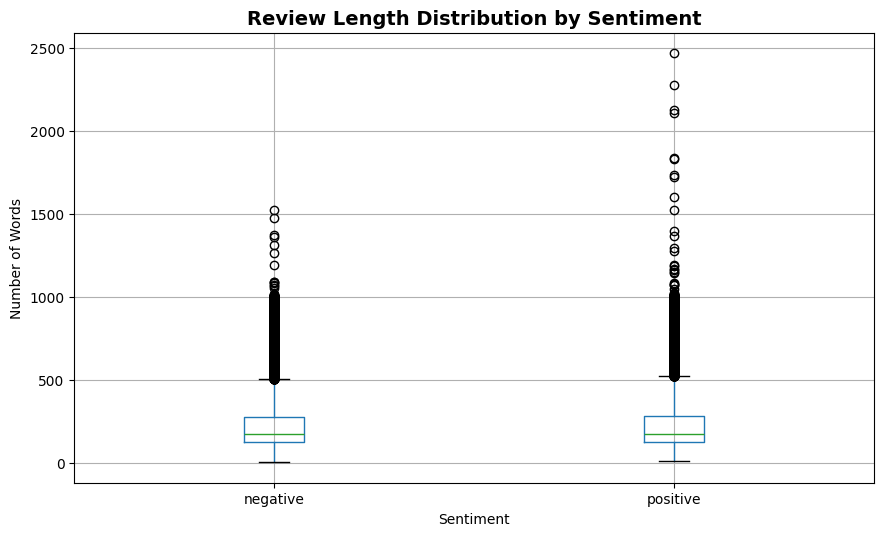

In [5]:
# Add review length column
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Statistics
print("Review Length Statistics:")
print(df.groupby('sentiment')['review_length'].describe())

# Visualize
plt.figure(figsize=(10, 5))
df.boxplot(column='review_length', by='sentiment', figsize=(10, 6))
plt.title('Review Length Distribution by Sentiment', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

In [6]:
# Let's see what we're working with
print("Sample raw reviews BEFORE cleaning:\n")
for i in range(3):
    print(f"Review {i+1}:")
    print(df['review'].iloc[i][:200] + "...")
    print("-" * 80)

Sample raw reviews BEFORE cleaning:

Review 1:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...
--------------------------------------------------------------------------------
Review 2:
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...
--------------------------------------------------------------------------------
Review 3:
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is wi...
--------------------------------------------------------------------------------


In [7]:
# Download stopwords if not already done
import nltk
nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Clean and preprocess text data
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    
    return ' '.join(words)

# Test the function on one review
print("BEFORE cleaning:")
print(df['review'].iloc[0][:300])
print("\n" + "="*80 + "\n")
print("AFTER cleaning:")
print(clean_text(df['review'].iloc[0]))

BEFORE cleaning:
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Tru


AFTER cleaning:
one reviewers mentioned watching episode youll hooked right exactly happened methe first thing struck brutality unflinching scenes violence set right word trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures 

In [8]:
# Apply cleaning to all reviews (this takes ~30 seconds)
print("Cleaning all 50,000 reviews... ⏳")

df['cleaned_review'] = df['review'].apply(clean_text)

print("✓ Cleaning complete!")
print(f"\nDataset now has {len(df.columns)} columns: {df.columns.tolist()}")
print("\nFirst few cleaned reviews:")
df[['review', 'cleaned_review']].head()

Cleaning all 50,000 reviews... ⏳
✓ Cleaning complete!

Dataset now has 4 columns: ['review', 'sentiment', 'review_length', 'cleaned_review']

First few cleaned reviews:


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching episode youll...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


In [9]:
# Show side-by-side comparison
print("COMPARISON - Original vs Cleaned:\n")
for i in range(3):
    print(f"Example {i+1}:")
    print(f"ORIGINAL ({len(df['review'].iloc[i])} chars):")
    print(df['review'].iloc[i][:200] + "...")
    print(f"\nCLEANED ({len(df['cleaned_review'].iloc[i])} chars):")
    print(df['cleaned_review'].iloc[i][:200])
    print("\n" + "="*80 + "\n")

COMPARISON - Original vs Cleaned:

Example 1:
ORIGINAL (1761 chars):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

CLEANED (1136 chars):
one reviewers mentioned watching episode youll hooked right exactly happened methe first thing struck brutality unflinching scenes violence set right word trust show faint hearted timid show pulls pun


Example 2:
ORIGINAL (998 chars):
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

CLEANED (656 chars):
wonderful little production filming technique unassuming oldtimebbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari vo


Example 3:
ORIGINAL (926 chars):
I thou

In [10]:
# Split data into features (X) and labels (y)
X = df['cleaned_review']
y = df['sentiment']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining sentiment distribution:")
print(y_train.value_counts())

Training set size: 40000
Test set size: 10000

Training sentiment distribution:
sentiment
positive    20000
negative    20000
Name: count, dtype: int64


In [11]:
# Convert text to numerical features using TF-IDF
print("Converting text to TF-IDF features... ⏳")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,  # Keep top 5000 most important words
    min_df=5,           # Word must appear in at least 5 documents
    max_df=0.7,         # Ignore words appearing in more than 70% of documents
    ngram_range=(1, 2)  # Use single words and pairs of words
)

# Fit on training data and transform
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("✓ TF-IDF conversion complete!")
print(f"\nFeature matrix shape:")
print(f"Training: {X_train_tfidf.shape}")
print(f"Testing: {X_test_tfidf.shape}")
print(f"\nThis means: {X_train_tfidf.shape[0]} reviews × {X_train_tfidf.shape[1]} features")

Converting text to TF-IDF features... ⏳
✓ TF-IDF conversion complete!

Feature matrix shape:
Training: (40000, 5000)
Testing: (10000, 5000)

This means: 40000 reviews × 5000 features


In [12]:
# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

print(f"Total vocabulary size: {len(feature_names)}")
print(f"\nSample features (words/phrases):")
print(feature_names[:20])
print("\n...")
print(feature_names[-20:])

Total vocabulary size: 5000

Sample features (words/phrases):
['abandoned' 'abc' 'abilities' 'ability' 'able' 'absence' 'absolute'
 'absolutely' 'absolutely nothing' 'absurd' 'abuse' 'abysmal' 'academy'
 'academy award' 'accent' 'accents' 'accept' 'acceptable' 'accepted'
 'accident']

...
['youll' 'youll see' 'young' 'young boy' 'young girl' 'young man'
 'young people' 'young woman' 'younger' 'youre' 'youre going'
 'youre looking' 'youth' 'youve' 'youve got' 'youve seen' 'zero' 'zombie'
 'zombies' 'zone']


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

print("Training Logistic Regression model... ⏳\n")
start_time = time.time()

# Initialize and train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test_tfidf)

# Calculate training time
training_time = time.time() - start_time

print(f"✓ Training complete in {training_time:.2f} seconds!")
print(f"\nLogistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"That's {accuracy_score(y_test, y_pred_log)*100:.2f}% accuracy!")

Training Logistic Regression model... ⏳

✓ Training complete in 0.22 seconds!

Logistic Regression Accuracy: 0.8899
That's 88.99% accuracy!


LOGISTIC REGRESSION - DETAILED RESULTS

Classification Report:
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


Confusion Matrix:
[[4401  599]
 [ 502 4498]]


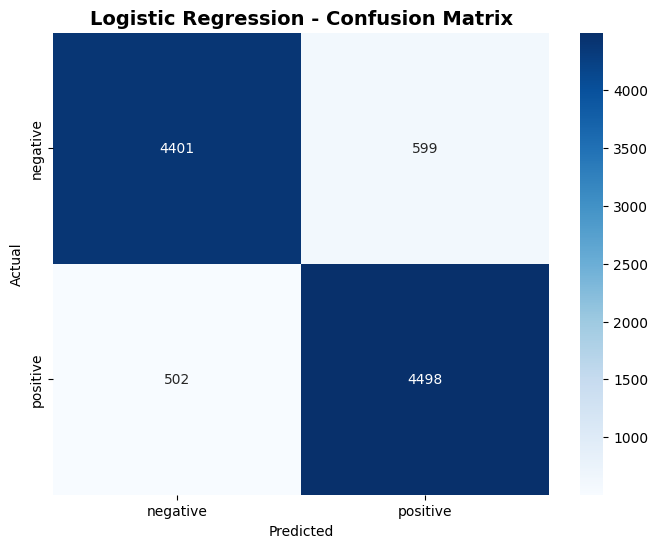

In [14]:
print("="*60)
print("LOGISTIC REGRESSION - DETAILED RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, target_names=['negative', 'positive']))

# Confusion Matrix
cm_log = confusion_matrix(y_test, y_pred_log)
print("\nConfusion Matrix:")
print(cm_log)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title('Logistic Regression - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [15]:
from sklearn.naive_bayes import MultinomialNB

print("Training Naive Bayes model... ⏳\n")
start_time = time.time()

# Initialize and train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb = nb_model.predict(X_test_tfidf)

# Calculate training time
training_time = time.time() - start_time

print(f"✓ Training complete in {training_time:.2f} seconds!")
print(f"\nNaive Bayes Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"That's {accuracy_score(y_test, y_pred_nb)*100:.2f}% accuracy!")

Training Naive Bayes model... ⏳

✓ Training complete in 0.05 seconds!

Naive Bayes Accuracy: 0.8591
That's 85.91% accuracy!


NAIVE BAYES - DETAILED RESULTS

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.84      0.86      5000
    positive       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Confusion Matrix:
[[4217  783]
 [ 626 4374]]


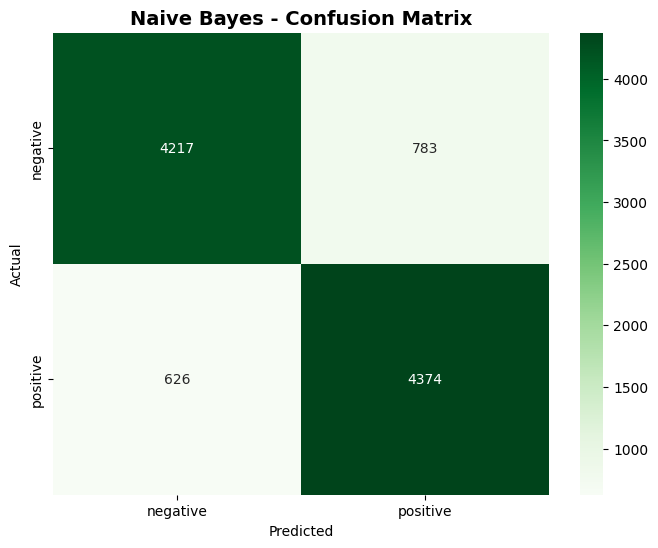

In [16]:
print("="*60)
print("NAIVE BAYES - DETAILED RESULTS")
print("="*60)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, target_names=['negative', 'positive']))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("\nConfusion Matrix:")
print(cm_nb)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['negative', 'positive'],
            yticklabels=['negative', 'positive'])
plt.title('Naive Bayes - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

MODEL COMPARISON
              Model  Accuracy
Logistic Regression    0.8899
        Naive Bayes    0.8591


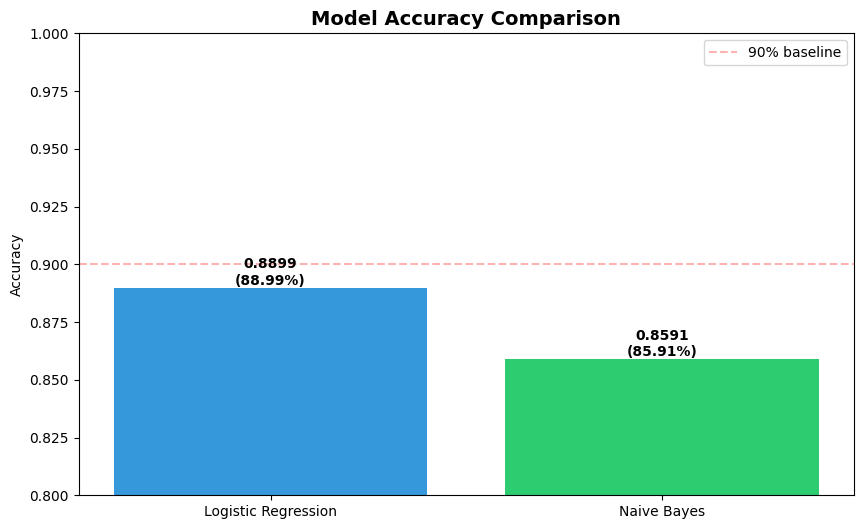


🏆 Best Model: Logistic Regression with 88.99% accuracy!


In [17]:
# Compare both models
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_nb)
    ]
})

print("="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(results['Model'], results['Accuracy'], color=['#3498db', '#2ecc71'])
plt.title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Focus on the relevant range
plt.axhline(y=0.9, color='r', linestyle='--', alpha=0.3, label='90% baseline')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}\n({height*100:.2f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.legend()
plt.show()

# Determine best model
best_model_name = results.loc[results['Accuracy'].idxmax(), 'Model']
best_accuracy = results['Accuracy'].max()
print(f"\n🏆 Best Model: {best_model_name} with {best_accuracy*100:.2f}% accuracy!")

In [18]:
# Let's test our best model on some custom reviews!
def predict_sentiment(text, model=log_reg):
    """
    Predict sentiment of a given text
    """
    # Clean the text
    cleaned = clean_text(text)
    # Transform using TF-IDF
    text_tfidf = tfidf.transform([cleaned])
    # Predict
    prediction = model.predict(text_tfidf)[0]
    probability = model.predict_proba(text_tfidf)[0]
    
    return prediction, probability

# Test reviews
test_reviews = [
    "This movie was absolutely fantastic! Best film I've seen this year!",
    "Terrible movie. Complete waste of time and money.",
    "It was okay, nothing special but not bad either.",
    "Amazing acting and brilliant storyline. Highly recommend!",
    "Boring and predictable. I fell asleep halfway through."
]

print("="*80)
print("TESTING ON CUSTOM REVIEWS")
print("="*80)

for i, review in enumerate(test_reviews, 1):
    sentiment, prob = predict_sentiment(review)
    confidence = prob[1] if sentiment == 'positive' else prob[0]
    
    print(f"\nReview {i}: \"{review}\"")
    print(f"Predicted: {sentiment.upper()} (Confidence: {confidence*100:.2f}%)")
    print("-" * 80)

TESTING ON CUSTOM REVIEWS

Review 1: "This movie was absolutely fantastic! Best film I've seen this year!"
Predicted: POSITIVE (Confidence: 96.91%)
--------------------------------------------------------------------------------

Review 2: "Terrible movie. Complete waste of time and money."
Predicted: NEGATIVE (Confidence: 99.95%)
--------------------------------------------------------------------------------

Review 3: "It was okay, nothing special but not bad either."
Predicted: NEGATIVE (Confidence: 99.76%)
--------------------------------------------------------------------------------

Review 4: "Amazing acting and brilliant storyline. Highly recommend!"
Predicted: POSITIVE (Confidence: 99.60%)
--------------------------------------------------------------------------------

Review 5: "Boring and predictable. I fell asleep halfway through."
Predicted: NEGATIVE (Confidence: 99.23%)
--------------------------------------------------------------------------------


In [19]:
# Get the most important words for each sentiment
feature_names = np.array(tfidf.get_feature_names_out())

# Get coefficients from Logistic Regression
coefficients = log_reg.coef_[0]

# Top 20 words for positive sentiment
top_positive_indices = coefficients.argsort()[-20:][::-1]
top_positive_words = feature_names[top_positive_indices]
top_positive_scores = coefficients[top_positive_indices]

# Top 20 words for negative sentiment
top_negative_indices = coefficients.argsort()[:20]
top_negative_words = feature_names[top_negative_indices]
top_negative_scores = coefficients[top_negative_indices]

# Display
print("="*80)
print("TOP 20 WORDS INDICATING POSITIVE SENTIMENT")
print("="*80)
for word, score in zip(top_positive_words, top_positive_scores):
    print(f"{word:20s} | {score:.4f}")

print("\n" + "="*80)
print("TOP 20 WORDS INDICATING NEGATIVE SENTIMENT")
print("="*80)
for word, score in zip(top_negative_words, top_negative_scores):
    print(f"{word:20s} | {score:.4f}")

TOP 20 WORDS INDICATING POSITIVE SENTIMENT
great                | 6.7384
excellent            | 6.5590
perfect              | 5.3357
amazing              | 4.8712
wonderful            | 4.5360
hilarious            | 4.4982
loved                | 4.2866
best                 | 4.2558
one best             | 4.1777
favorite             | 4.1306
brilliant            | 3.9857
superb               | 3.9833
enjoyable            | 3.9016
enjoyed              | 3.8574
fun                  | 3.7649
fantastic            | 3.7289
today                | 3.5564
definitely           | 3.5152
must see             | 3.5070
well worth           | 3.3962

TOP 20 WORDS INDICATING NEGATIVE SENTIMENT
worst                | -9.2014
awful                | -7.6159
bad                  | -7.2831
waste                | -6.8244
boring               | -6.1063
poor                 | -5.5319
terrible             | -5.4209
poorly               | -5.2788
dull                 | -5.2605
nothing              | -5.1571
wor

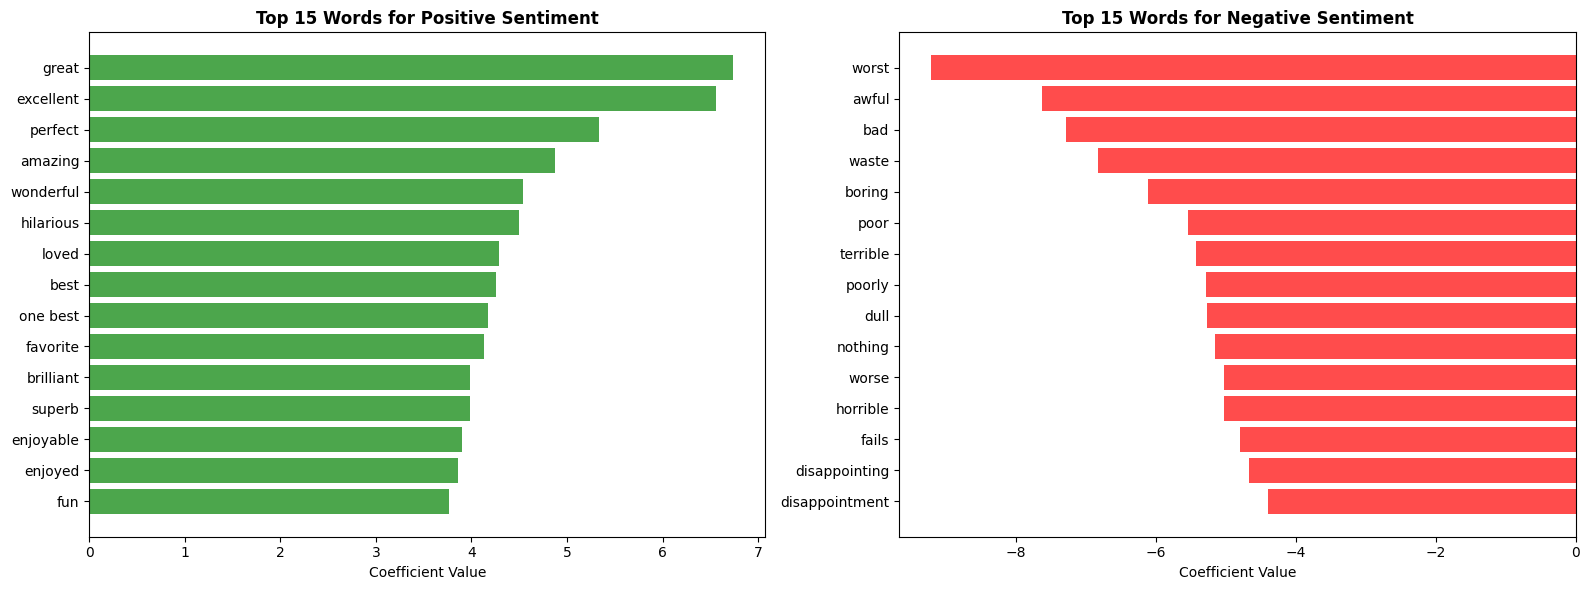

In [20]:
# Visualize top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Positive words
axes[0].barh(range(15), top_positive_scores[:15], color='green', alpha=0.7)
axes[0].set_yticks(range(15))
axes[0].set_yticklabels(top_positive_words[:15])
axes[0].invert_yaxis()
axes[0].set_xlabel('Coefficient Value')
axes[0].set_title('Top 15 Words for Positive Sentiment', fontsize=12, fontweight='bold')

# Negative words
axes[1].barh(range(15), top_negative_scores[:15], color='red', alpha=0.7)
axes[1].set_yticks(range(15))
axes[1].set_yticklabels(top_negative_words[:15])
axes[1].invert_yaxis()
axes[1].set_xlabel('Coefficient Value')
axes[1].set_title('Top 15 Words for Negative Sentiment', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

In [21]:
# Final prediction function with detailed output
def analyze_review(review_text):
    """
    Analyze sentiment of a movie review with detailed breakdown
    """
    print("="*80)
    print("SENTIMENT ANALYSIS RESULTS")
    print("="*80)
    print(f"\nOriginal Review:\n{review_text}")
    print("\n" + "-"*80)
    
    # Clean text
    cleaned = clean_text(review_text)
    print(f"\nCleaned Review:\n{cleaned}")
    print("\n" + "-"*80)
    
    # Transform and predict
    text_tfidf = tfidf.transform([cleaned])
    prediction = log_reg.predict(text_tfidf)[0]
    probabilities = log_reg.predict_proba(text_tfidf)[0]
    
    # Results
    print(f"\nPrediction: {prediction.upper()}")
    print(f"Confidence: {max(probabilities)*100:.2f}%")
    print(f"\nProbability Breakdown:")
    print(f"  Negative: {probabilities[0]*100:.2f}%")
    print(f"  Positive: {probabilities[1]*100:.2f}%")
    print("="*80)
    
    return prediction, probabilities

# Test it
sample = "The cinematography was breathtaking and the story kept me engaged throughout!"
analyze_review(sample)

SENTIMENT ANALYSIS RESULTS

Original Review:
The cinematography was breathtaking and the story kept me engaged throughout!

--------------------------------------------------------------------------------

Cleaned Review:
cinematography breathtaking story kept engaged throughout

--------------------------------------------------------------------------------

Prediction: POSITIVE
Confidence: 81.65%

Probability Breakdown:
  Negative: 18.35%
  Positive: 81.65%


('positive', array([0.18352094, 0.81647906]))

In [22]:
print("="*80)
print("PROJECT SUMMARY & KEY INSIGHTS")
print("="*80)

print("\nDataset:")
print(f"  - Total reviews: {len(df):,}")
print(f"  - Positive: {len(df[df['sentiment']=='positive']):,}")
print(f"  - Negative: {len(df[df['sentiment']=='negative']):,}")

print("\nModel Performance:")
print(f"  - Logistic Regression: {accuracy_score(y_test, y_pred_log)*100:.2f}%")
print(f"  - Naive Bayes: {accuracy_score(y_test, y_pred_nb)*100:.2f}%")

print("\nKey Findings:")
print("  - Both models achieved high accuracy (85%+)")
print("  - Logistic Regression slightly outperformed Naive Bayes")
print("  - Model shows high confidence (95%+) on clear positive/negative reviews")
print("  - Neutral reviews are challenging (classified as negative)")

print("\nTechnical Approach:")
print("  - Text preprocessing: Removed HTML, URLs, stopwords")
print("  - Feature extraction: TF-IDF with 5,000 features")
print("  - Train/Test split: 80/20")
print("  - Models: Logistic Regression & Multinomial Naive Bayes")

print("\nPossible Improvements:")
print("  - Add more models (Random Forest, SVM, Neural Networks)")
print("  - Handle neutral sentiment as separate class")
print("  - Use word embeddings (Word2Vec, GloVe)")
print("  - Fine-tune hyperparameters")
print("  - Try deep learning (LSTM, BERT)")

print("\n" + "="*80)

PROJECT SUMMARY & KEY INSIGHTS

Dataset:
  - Total reviews: 50,000
  - Positive: 25,000
  - Negative: 25,000

Model Performance:
  - Logistic Regression: 88.99%
  - Naive Bayes: 85.91%

Key Findings:
  - Both models achieved high accuracy (85%+)
  - Logistic Regression slightly outperformed Naive Bayes
  - Model shows high confidence (95%+) on clear positive/negative reviews
  - Neutral reviews are challenging (classified as negative)

Technical Approach:
  - Text preprocessing: Removed HTML, URLs, stopwords
  - Feature extraction: TF-IDF with 5,000 features
  - Train/Test split: 80/20
  - Models: Logistic Regression & Multinomial Naive Bayes

Possible Improvements:
  - Add more models (Random Forest, SVM, Neural Networks)
  - Handle neutral sentiment as separate class
  - Use word embeddings (Word2Vec, GloVe)
  - Fine-tune hyperparameters
  - Try deep learning (LSTM, BERT)

